In [1]:
import numpy as np
import pandas as pd
from collections import namedtuple
from copy import deepcopy


NUMBER_OF_PARTS = 50
POPULATION_OF_GENERATION = 200


Part = namedtuple("Part", "R T D")


#Wczytujemy dane do słownika
df = pd.read_excel('GA_task.xlsx')
part_processing_data = []
for i in range(0, NUMBER_OF_PARTS*2, 2):
    part = Part(
        R = list(df[f'Unnamed: {i}'][1:]),
        T = list(df[f'Unnamed: {i+1}'][1:]),
        D = [False] * 11
    )
    part_processing_data.append(part)

In [2]:
import matplotlib.pyplot as plt
from collections import Counter


class GanttGraph:
    def __init__(self, part_processing_data) -> None:
        self.part_processing_data = deepcopy(part_processing_data)
        self.timestamps = [0]*10

    def convert_genotype_to_graph_data(self, genotype):
        genotype = deepcopy(genotype)
        machines_timetable = [[] for _ in range(10)]
        self.timestamps = [0]*10
        for gene in genotype:
            part_number = gene
            current_task = self._take_first_not_done_task(gene)
            top_deadline = self._get_start_of_task(part_number, machines_timetable)
            machine_number = current_task[0] - 1
            time_of_operation = current_task[1]
            timestamp = self.timestamps[machine_number]
            if self._collision_occured(timestamp, top_deadline):
                self.timestamps[machine_number] = top_deadline + time_of_operation
                machines_timetable[machine_number].append((top_deadline, top_deadline+time_of_operation, part_number))
            else:
                self.timestamps[machine_number] = timestamp + time_of_operation
                machines_timetable[machine_number].append((timestamp, timestamp+time_of_operation, part_number))
        return machines_timetable
    
    def _collision_occured(self, timestamp, top_deadline):
        if timestamp < top_deadline:
            return True
        else:
            return False
        
    def _get_start_of_task(self, part_number, machine_timetable):
        top_deadline = 0
        max_deadline_in_timetable = 0
        for timetable in machine_timetable:
            try:
                max_deadline_in_timetable = max((task for task in timetable if task[2] == part_number), key=lambda x: x[1])
                max_deadline_in_timetable = max_deadline_in_timetable[1]
            except:
                pass
            if max_deadline_in_timetable > top_deadline:
                top_deadline = max_deadline_in_timetable
        return top_deadline

    def _take_first_not_done_task(self, gene):
        part = part_processing_data[gene]
        for i, task_status in enumerate(part.D):
            if task_status == False:
                part.D[i] = True
                return (part.R[i], part.T[i])

    def draw_graph(self, machine_timetable):
        fig, ax = plt.subplots(figsize=(10, len(machine_timetable)*0.5))

        for i, task in enumerate(machine_timetable):
            for start, end, worker_id in task:
                ax.barh(i, width=(end-start), left=start, height=0.3, align='center', edgecolor='k')
                ax.text(start + (end-start)/2, i, str(worker_id), ha='center', va='center', color='white')

        ax.set_xlabel('Czas')
        ax.set_ylabel('Zadania')
        ax.set_yticks(range(len(machine_timetable)))
        ax.set_yticklabels([f'Zadanie {i+1}' for i in range(len(machine_timetable))])
        ax.grid(True)

        plt.show()

In [3]:
import random
import pandas as pd


class GeneticAlgorythm(GanttGraph):
    def __init__(self, part_processing_data, number_of_genes_to_mutate, n_best) -> None:
        super().__init__(part_processing_data)
        self.number_of_genes_to_mutate = number_of_genes_to_mutate
        self.n_best = n_best
        self.chance_of_crossing = 0.8
        self.chance_of_mutation = 0.2

    def create_first_generation(self, number_of_individuals):
        genotype_base = []
        generation = []
        for i in range(NUMBER_OF_PARTS):
            for _ in range(11):
                genotype_base.append(i)
        for _ in range(number_of_individuals):
            genotype = genotype_base.copy()
            random.shuffle(genotype)
            generation.append(genotype)
        return generation
    
    def calculate_fitness_of_generation(self, generation):
        fitness_of_generation = []
        for genotype in generation:
            self.convert_genotype_to_graph_data(genotype)
            fitness_of_generation.append(max(self.timestamps))
            self.clean_done_columns()
        return fitness_of_generation

    def clean_done_columns(self):
        for part in part_processing_data:
            for i, _ in enumerate(part.D):
                part.D[i] = False

    def cross_genotypes(self, genotype_1, genotype_2):
        genotype_1 = deepcopy(genotype_1)
        genotype_2 = deepcopy(genotype_2)
        start_of_cut = random.randint(1, len(genotype_1))

        genotype_1_clipped_part_1 = genotype_1[start_of_cut : ]
        genotype_1_clipped_part_2 = genotype_1[ : start_of_cut]
        genotype_2_clipped_part_1 = genotype_2[start_of_cut : ]
        genotype_2_clipped_part_2 = genotype_2[ : start_of_cut]

        genotype_1_child = self.correct_genotype(genotype_1_clipped_part_1, genotype_2_clipped_part_2)
        genotype_2_child = self.correct_genotype(genotype_2_clipped_part_1, genotype_1_clipped_part_2)

        return (deepcopy(genotype_1_child), deepcopy(genotype_2_child))
    
    def correct_genotype(self, clipped_part_1, clipped_part_2):
        clipped_part_1 = deepcopy(clipped_part_1)
        clipped_part_2 = deepcopy(clipped_part_2)
        clipped_part_2_copy = clipped_part_2.copy()
        whole_genotype = clipped_part_1 + clipped_part_2

        number_of_one_type_gene = Counter(whole_genotype)
        number_of_one_type_gene = dict(number_of_one_type_gene)
        #łatka na wypadek zerowego wystąpienia którejś z liczb
        for gene in range(NUMBER_OF_PARTS):
            if gene not in number_of_one_type_gene:
                number_of_one_type_gene[gene] = 0
        inbalance_in_genes_numbers = {}

        for gene in range(NUMBER_OF_PARTS):
            inbalance_in_genes_numbers[gene] = number_of_one_type_gene[gene] - 11

        #Jeśli danego genu zbyt duzo to zamieniamy go na -1 w drugiej części genotypu
        for gene in clipped_part_2_copy:
            gene = int(gene)
            if inbalance_in_genes_numbers[gene] > 0:
                indexes_of_gene = [i for i, x in enumerate(clipped_part_2) if x == gene]
                index_to_change = random.choice(indexes_of_gene)
                clipped_part_2[index_to_change] = -1
                #inbalance_in_genes_numbers[gene] -= 1

        whole_genotype = clipped_part_1 + clipped_part_2
        number_of_one_type_gene = Counter(whole_genotype)
        number_of_one_type_gene = dict(number_of_one_type_gene)
        #łatka na wypadek zerowego wystąpienia którejś z liczb
        for gene in range(NUMBER_OF_PARTS):
            if gene not in number_of_one_type_gene:
                number_of_one_type_gene[gene] = 0
        inbalance_in_genes_numbers = {}

        #Jzeli danego elementu jest zbyt mało to dodajemy go do listy inbalance_genes
        inbalance_genes = []
        for gene in range(NUMBER_OF_PARTS):
            number_of_gene_in_genotype = number_of_one_type_gene[gene]
            if 11 - number_of_gene_in_genotype > 0:
                for _ in range(11 - number_of_gene_in_genotype):
                    inbalance_genes.append(int(gene))

        #zamieniamy -1 na losowe brakujące elementy
        for i, gene in enumerate(clipped_part_2):
            if gene == -1:
                random.shuffle(inbalance_genes)
                clipped_part_2[i] = inbalance_genes.pop()

        whole_genotype = clipped_part_1 + clipped_part_2
        correct_genotype =  clipped_part_1 + clipped_part_2
        return correct_genotype
    
    def cross_generation(self, generation):
        generation = deepcopy(generation)
        for _ in range(len(generation)//2):
            parents = random.choices(generation, k=2)
            if random.random() < self.chance_of_crossing:
                children = self.cross_genotypes(parents[0], parents[1])
            else:
                children = (parents[0], parents[1])
            generation.append(children[0])
            generation.append(children[1])
        return generation
    
    def perform_mutations_on_generation(self, generation):
        generation = deepcopy(generation)
        mutated_generation = []
        for genotype in generation:
            mutated_genotype = genotype
            if random.random() < self.chance_of_mutation:
                mutated_genotype = self.mutate_genotype(genotype)
            mutated_generation.append(mutated_genotype)
        return mutated_generation
    
    def mutate_genotype(self, genotype):
        genotype = deepcopy(genotype)
        inxes = random.sample(range(len(genotype)), self.number_of_genes_to_mutate)
        for i in range(0, len(inxes), 2):
            genotype[inxes[i]], genotype[inxes[i+1]] = genotype[inxes[i+1]], genotype[inxes[i]]
        return deepcopy(genotype)
    
    def make_selection_with_n_elite(self, generation, fitness_of_generation, n_best_genotypes, n_best_fitnesses):
        generation = deepcopy(generation)
        fitness_of_generation = deepcopy(fitness_of_generation)
        sorted_data = sorted(zip(fitness_of_generation, generation))
        fitness_of_generation_scaled = [1/(fitness/1000) for fitness in fitness_of_generation]
        fitness_of_generation_scaled = [pow((fitness), 2) for fitness in fitness_of_generation]

        new_generation = deepcopy(n_best_genotypes)
        new_fitnesses = deepcopy(n_best_fitnesses)
        for _ in range(POPULATION_OF_GENERATION-len(n_best_fitnesses)):
            fitness_generation = random.choices(sorted_data, weights=fitness_of_generation_scaled, k=1)
            new_generation.append(fitness_generation[0][1])
            new_fitnesses.append(fitness_generation[0][0])

        sorted_data = sorted(zip(new_fitnesses, new_generation))
        sorted_fitness_of_generation = [data[0] for data in sorted_data]
        sorted_generation = [data[1] for data in sorted_data]

        return (sorted_generation, sorted_fitness_of_generation)
    
    def find_n_elite(self, generation, fitness_of_generation, n):
        generation = deepcopy(generation)
        fitness_of_generation = deepcopy(fitness_of_generation)
        sorted_data = sorted(zip(fitness_of_generation, generation))

        sorted_fitness_of_generation = [data[0] for data in sorted_data]
        sorted_generation = [data[1] for data in sorted_data]
        n_best_fintesses = sorted_fitness_of_generation[:n]
        n_best_generations = sorted_generation[:n]
        return (n_best_generations, n_best_fintesses)
    
    def perform_optimisations(self, threshold):
        generation = self.create_first_generation(POPULATION_OF_GENERATION)
        fitness_of_generation = self.calculate_fitness_of_generation(generation)
        i = 0
        while fitness_of_generation[0] > threshold:
            n_best_generations_fitnesses = self.find_n_elite(generation, fitness_of_generation, self.n_best)
            generation = self.cross_generation(generation)
            generation = self.perform_mutations_on_generation(generation)
            fitness_of_generation = self.calculate_fitness_of_generation(generation)
            generation_fitness = self.make_selection_with_n_elite(generation, fitness_of_generation, n_best_generations_fitnesses[0], n_best_generations_fitnesses[1])
            generation = generation_fitness[0]
            fitness_of_generation = generation_fitness[1]

            print(i, fitness_of_generation[0])
            i+=1

        gant_graph = GanttGraph(part_processing_data)
        machine_timetable = gant_graph.convert_genotype_to_graph_data(generation[0])
        gant_graph.draw_graph(machine_timetable)

0 2509
1 2509
2 2509
3 2479
4 2464
5 2464
6 2464
7 2464
8 2464
9 2464
10 2464
11 2464
12 2464
13 2464
14 2464
15 2450
16 2450
17 2433
18 2433
19 2433
20 2433
21 2433
22 2432
23 2432
24 2432
25 2432
26 2432
27 2432
28 2400
29 2400
30 2400
31 2400
32 2400
33 2400
34 2400
35 2400
36 2400
37 2400
38 2400
39 2400
40 2400
41 2400
42 2400
43 2400
44 2400
45 2354
46 2354
47 2354
48 2354
49 2354
50 2354
51 2354
52 2354
53 2354
54 2354
55 2354
56 2354
57 2354
58 2347
59 2347
60 2347
61 2347
62 2347
63 2347
64 2347
65 2347
66 2347
67 2347
68 2347
69 2347
70 2347
71 2347
72 2333
73 2333
74 2333
75 2333
76 2333
77 2333
78 2333
79 2333
80 2333
81 2333
82 2333
83 2333
84 2333
85 2332
86 2332
87 2332
88 2332
89 2332
90 2332
91 2332
92 2332
93 2332
94 2332
95 2332
96 2332
97 2330
98 2330
99 2330
100 2330
101 2330
102 2330
103 2323
104 2323
105 2323
106 2323
107 2323
108 2323
109 2315
110 2315
111 2315
112 2315
113 2315
114 2315
115 2315
116 2315
117 2315
118 2315
119 2315
120 2315
121 2315
122 2315
123

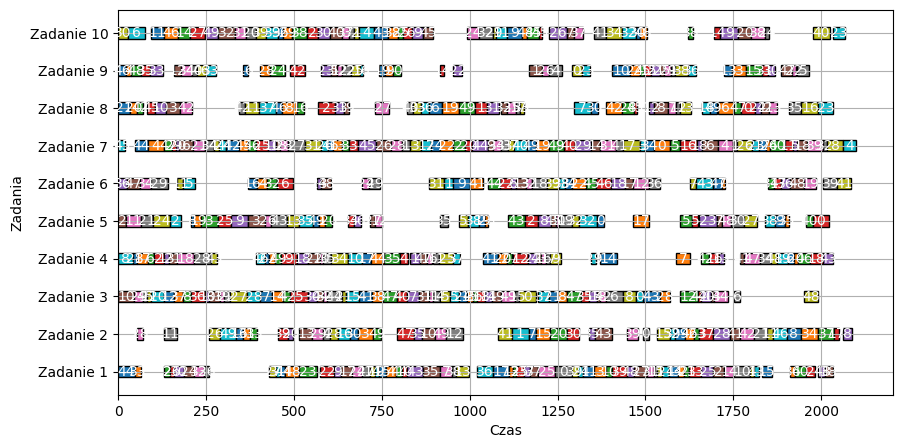

In [4]:

geneticAlgorythm = GeneticAlgorythm(part_processing_data, 4, 100)
geneticAlgorythm.perform_optimisations(2100)